<a href="https://colab.research.google.com/github/yatharthsameer/WebScrappers/blob/main/DL_Ass_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")


In [12]:
data = data.fillna(method="ffill")
data.tail(10)
words = list(set(data["Word"].values))
n_words = len(words); n_words
words = list(set(data["Word"].values))
n_words = len(words); n_words
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags


17

In [13]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [14]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)


[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [15]:
sentences = getter.sentences
max_len = 75
max_len_char = 10


In [16]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
print(word2idx["Obama"])
print(tag2idx["B-geo"])


30987
17


In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]


In [23]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


98


In [24]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [25]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [26]:
from sklearn.model_selection import train_test_split


In [27]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


In [29]:
from keras.models import Model
from tensorflow.keras.layers import Input

from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


In [30]:
# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)


In [31]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 75, 10)]     0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 75)]         0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 75, 10, 10)  1000        ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 75, 20)       703600      ['input_1[0][0]']            

In [33]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=1, validation_split=0.1, verbose=1)


1214/1214 [==============================] - 406s 335ms/step - loss: 0.1089 - acc: 0.9685 - val_loss: 0.1143 - val_acc: 0.9665


In [34]:
hist = pd.DataFrame(history.history)


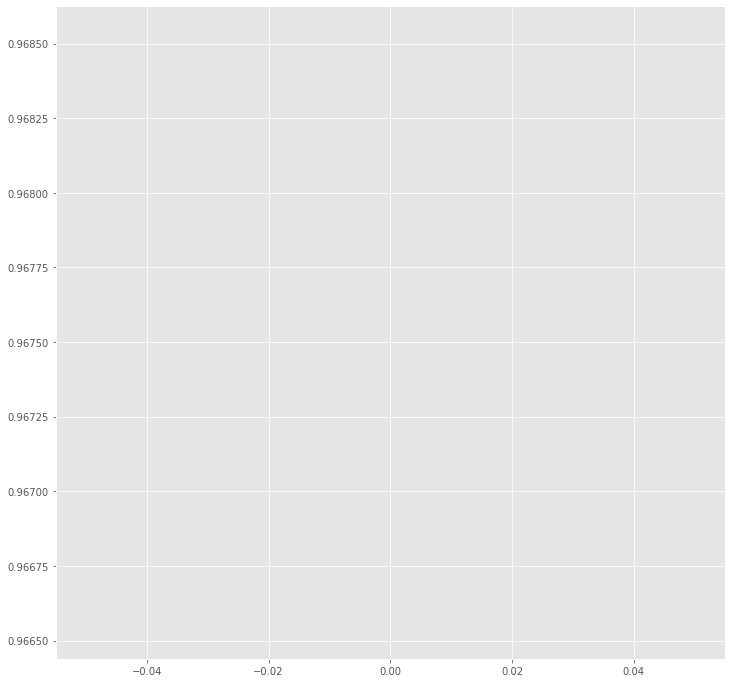

In [35]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [36]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


150/150 [==============================] - 13s 81ms/step


In [37]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per O
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O
